# Speech feature visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from speech_study.audio_ptcpt_filtering import add_audio_mask
from speech_study.data_parsing import add_block_mask
from speech_study.path_conf import loc_data_dir

In [3]:
df_feat_tot = pd.read_parquet(loc_data_dir.joinpath("df_speech_feat_tot.parquet"))

## Participant filtering

In [4]:
add_block_mask(df_feat_tot)
add_audio_mask(df_feat_tot);

### Filtering stats

In [23]:
bad_audio = df_feat_tot.bad_audio
print("nb neutral removed  ", (bad_audio & (df_feat_tot.block == 'neutral')).sum())
print("nb negative removed ", (bad_audio & (df_feat_tot.block == 'negative')).sum())
print("nb feedback removed ", (bad_audio & df_feat_tot.block.notna()).sum())

print()
print("nb neutral remaining  ", (~bad_audio  & (df_feat_tot.block == 'neutral')).sum())
print("nb negative remaining ", (~bad_audio & (df_feat_tot.block == 'negative')).sum())
print("nb feedback remaining ", (~bad_audio & df_feat_tot.block.notna()).sum())

print()
print("total neutral  ",  (df_feat_tot.block == 'neutral').sum())
print("total negative ", (df_feat_tot.block == 'negative').sum())

print()
print(
    "nb unique participant before                                              ", 
    df_feat_tot[df_feat_tot.block.notna()].participantNum.nunique(),
)
print(
    "nb unique participants with at least 1 feedback recording after filtering ",
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())
    ].participantNum.nunique(),
)

nb neutral removed   31
nb negative removed  34
nb feedback removed  65

nb neutral remaining   206
nb negative remaining  203
nb feedback remaining  409

total neutral   237
total negative  237

nb unique participant before                                               79
nb unique participants with at least 1 feedback recording after filtering  71


# Visualizations

## `GeMAPS`

### Block comparison

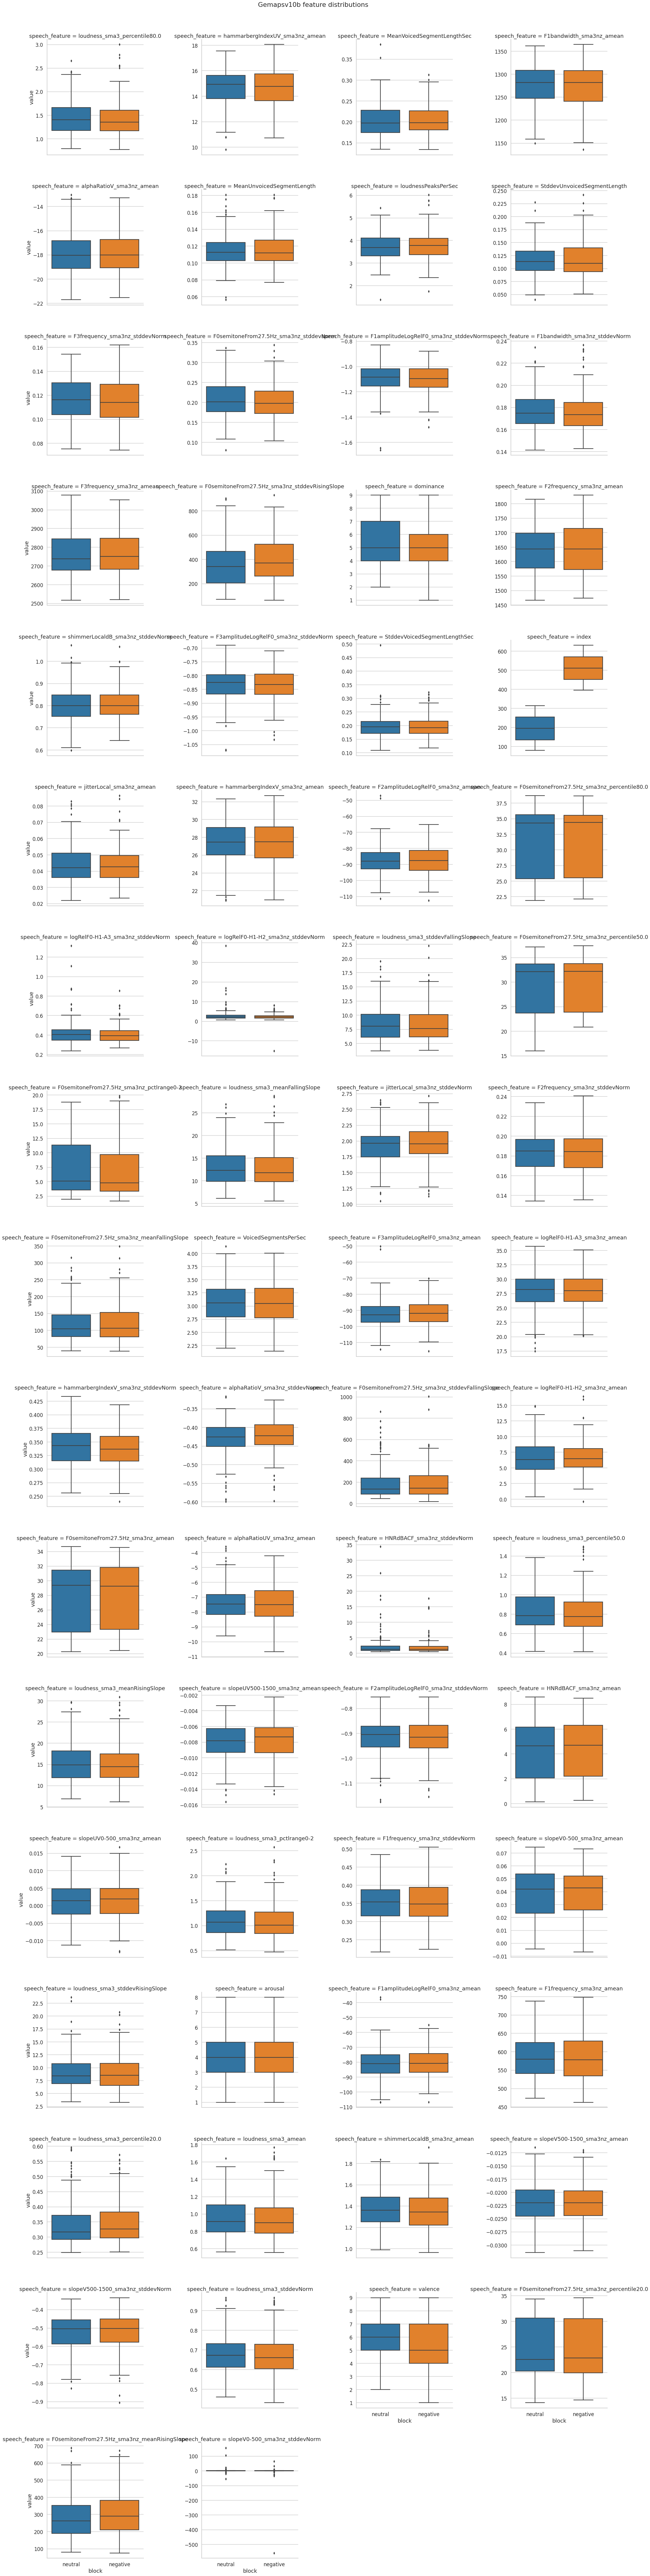

In [5]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())],
        id_vars=["file", "fileName", "fileNum", "block", "participantNum"],
        value_vars=set(df_feat_tot.columns).difference(
            {
                "file",
                "start",
                "end",
                "fileName",
                "fileNum",
                "block",
                "bad_audio",
                "participantNum",
                # also to not visualize the LLD quantile's + counts
                *list(
                    list(df_feat_tot.filter(like="q=").columns.values)
                    + list(df_feat_tot.filter(like="nzcount").columns.values)
                ),
            }
        ),
        value_name="value",
        var_name="speech_feature",
    ),
    x="block",
    y="value",
    col="speech_feature",
    col_wrap=4,
    height=7,
    kind="box",
    sharey=False,
    sharex=True,
)
g.fig.suptitle("Gemapsv10b feature distributions", y=1.01)
plt.subplots_adjust(wspace=0.6, hspace=0.3)

### Per participant difference plot

In [6]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())]
    .groupby(["participantNum", "block"])
    .mean()
    .reset_index()
)
mean_contr_func = mean_func[mean_func.block == "neutral"].set_index("participantNum")
mean_stress_func = mean_func[mean_func.block == "negative"].set_index("participantNum")
feat_cols: List[str] = list(
    set(df_feat_tot.columns).difference(
        {
            "file",
            "start",
            "end",
            "fileName",
            "fileNum",
            "block",
            "bad_audio",
            "participantNum",
            # also to not visualize the LLD quantile's + counts
            *list(
                list(df_feat_tot.filter(like="q=").columns.values)
                + list(df_feat_tot.filter(like="nzcount").columns.values)
            ),
        }
    )
)
#
mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]

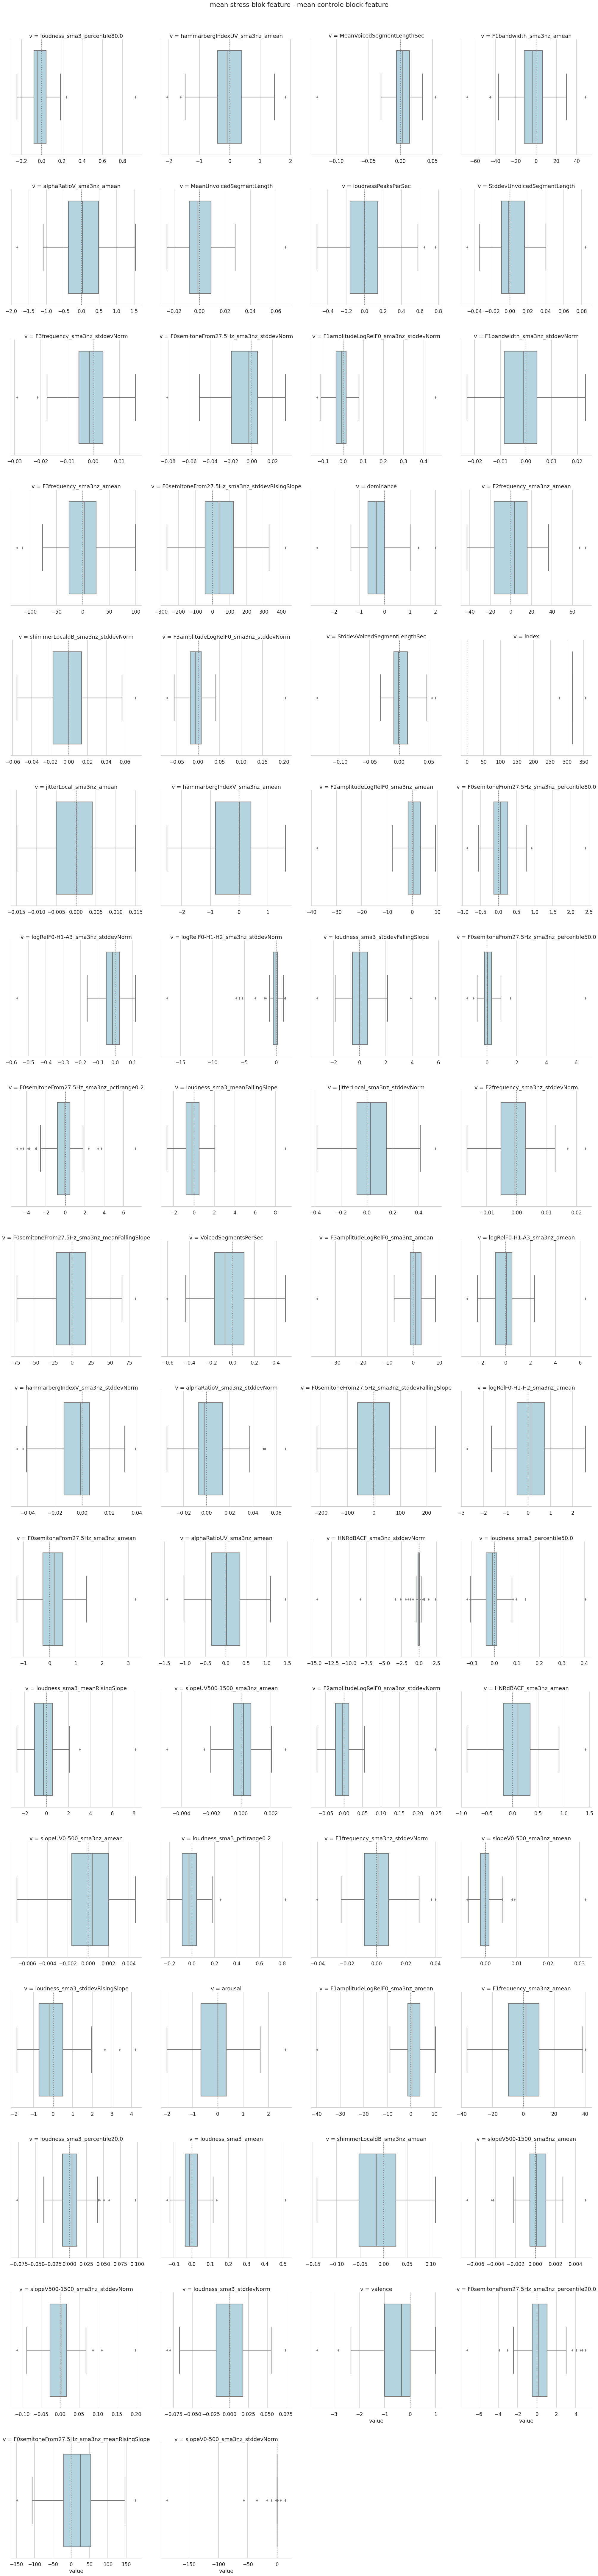

In [7]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(
                set(mean_stress_func.index)
                .difference(mean_contr_func.index)
                .union(set(mean_contr_func.index).difference(mean_stress_func.index))
            )
        )
    ].melt(var_name="v"),
    col="v",
    x="value",
    kind="box",
    height=7,
    col_wrap=4,
    sharex=False,
    color="lightblue",
)
g.fig.suptitle("mean stress-block feature - mean controle block-feature", y=1.01)
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")
plt.subplots_adjust(wspace=0.15, hspace=0.3)

## `LLD's`: F0-range

### Block comparison

In [8]:
qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], [])
q_med = [0.5]

In [9]:
for sig in ["F0final_sma", "F0semitoneFrom27.5Hz_sma3nz"]:
    for (max_q, min_q) in list(zip(qs[::2], qs[1::2])):
        max_q_col = "_".join([sig, f"q={max_q}"])
        min_q_col = "_".join([sig, f"q={min_q}"])

        df_feat_tot[f"{sig}_qd={max_q}-{min_q}"] = (
            df_feat_tot[max_q_col] - df_feat_tot[min_q_col]
        )

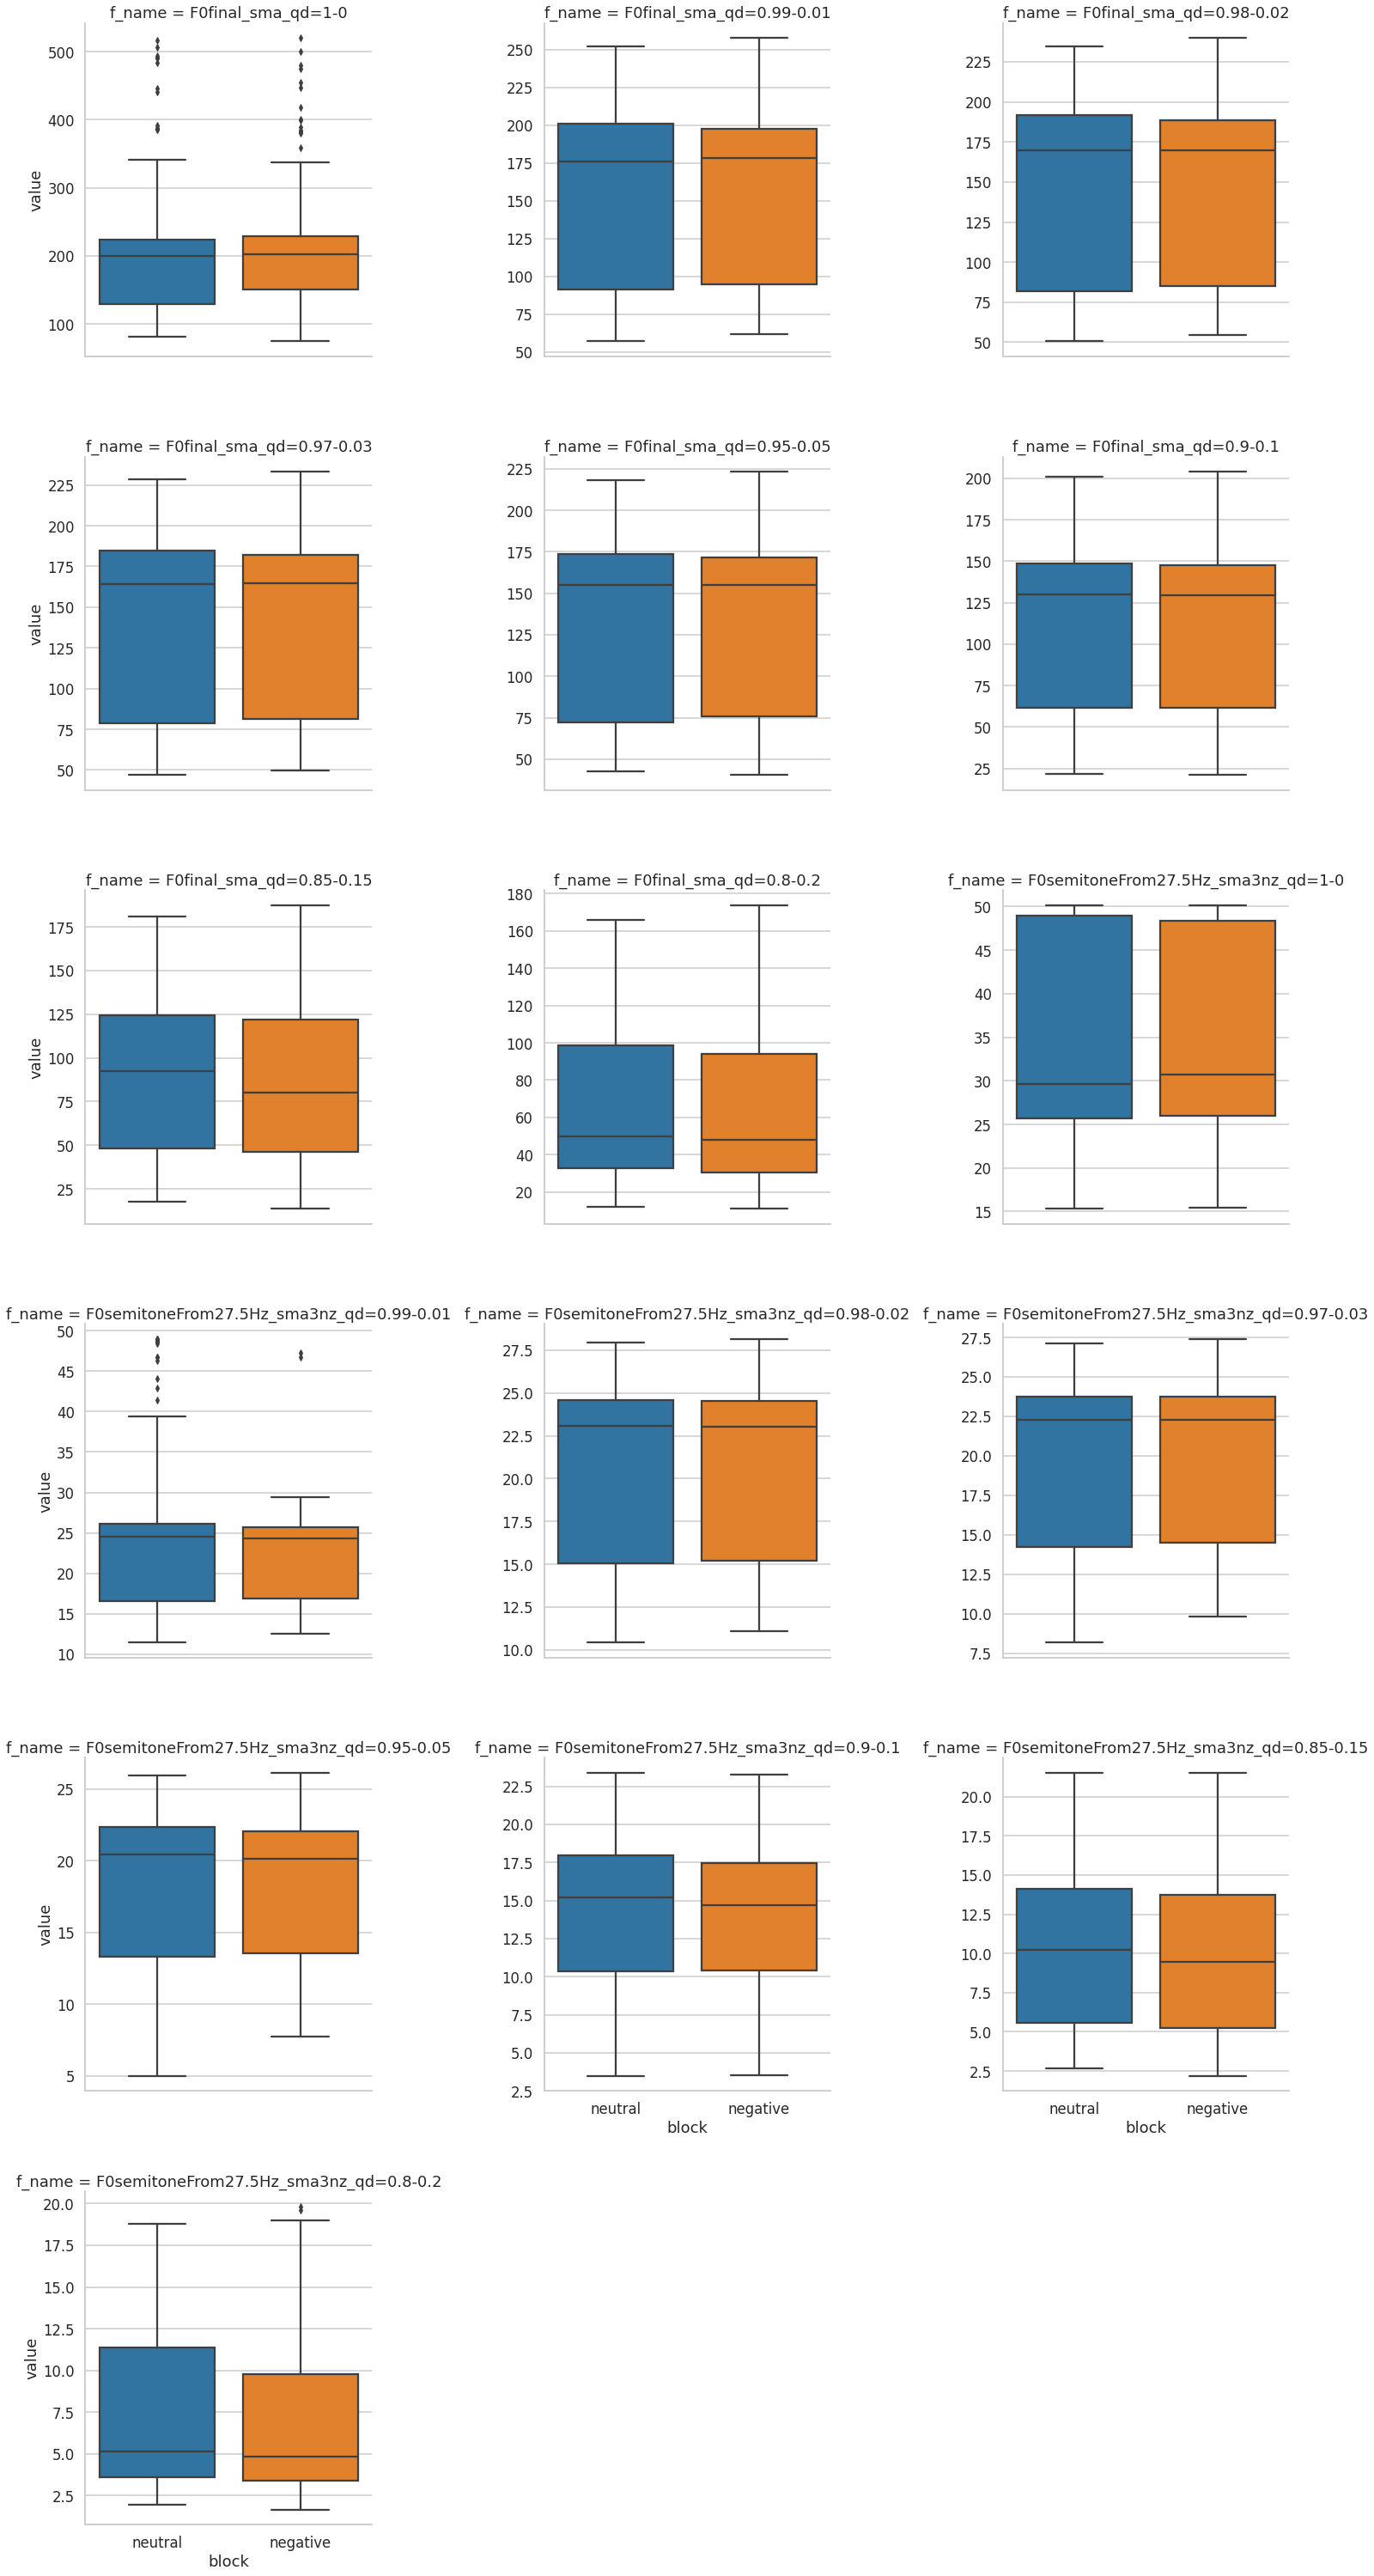

In [10]:
sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())],
        id_vars=["file", "fileName", "fileNum", "block", "participantNum"],
        value_vars=list(df_feat_tot.filter(like="qd=").columns.values),
        value_name="value",
        var_name="f_name",
    ),
    x="block",
    y="value",
    col="f_name",
    col_wrap=3,
    height=7,
    sharey=False,
    kind="box",
)
plt.subplots_adjust(wspace=0.6, hspace=0.3)

### Per participant difference plot

In [11]:
# calculate the mean per participant, per block
# TODO -> maybe use the reference values? and subtract the control / stress block
# from these reference values
mean_func = (
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.block.notna())]
    .groupby(["participantNum", "block"])
    .mean()
    .reset_index()
)
mean_contr_func = mean_func[mean_func.block == "neutral"].set_index("participantNum")
mean_stress_func = mean_func[mean_func.block == "negative"].set_index("participantNum")
feat_cols: List[str] = list(df_feat_tot.filter(like="qd=").columns.values)

mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]

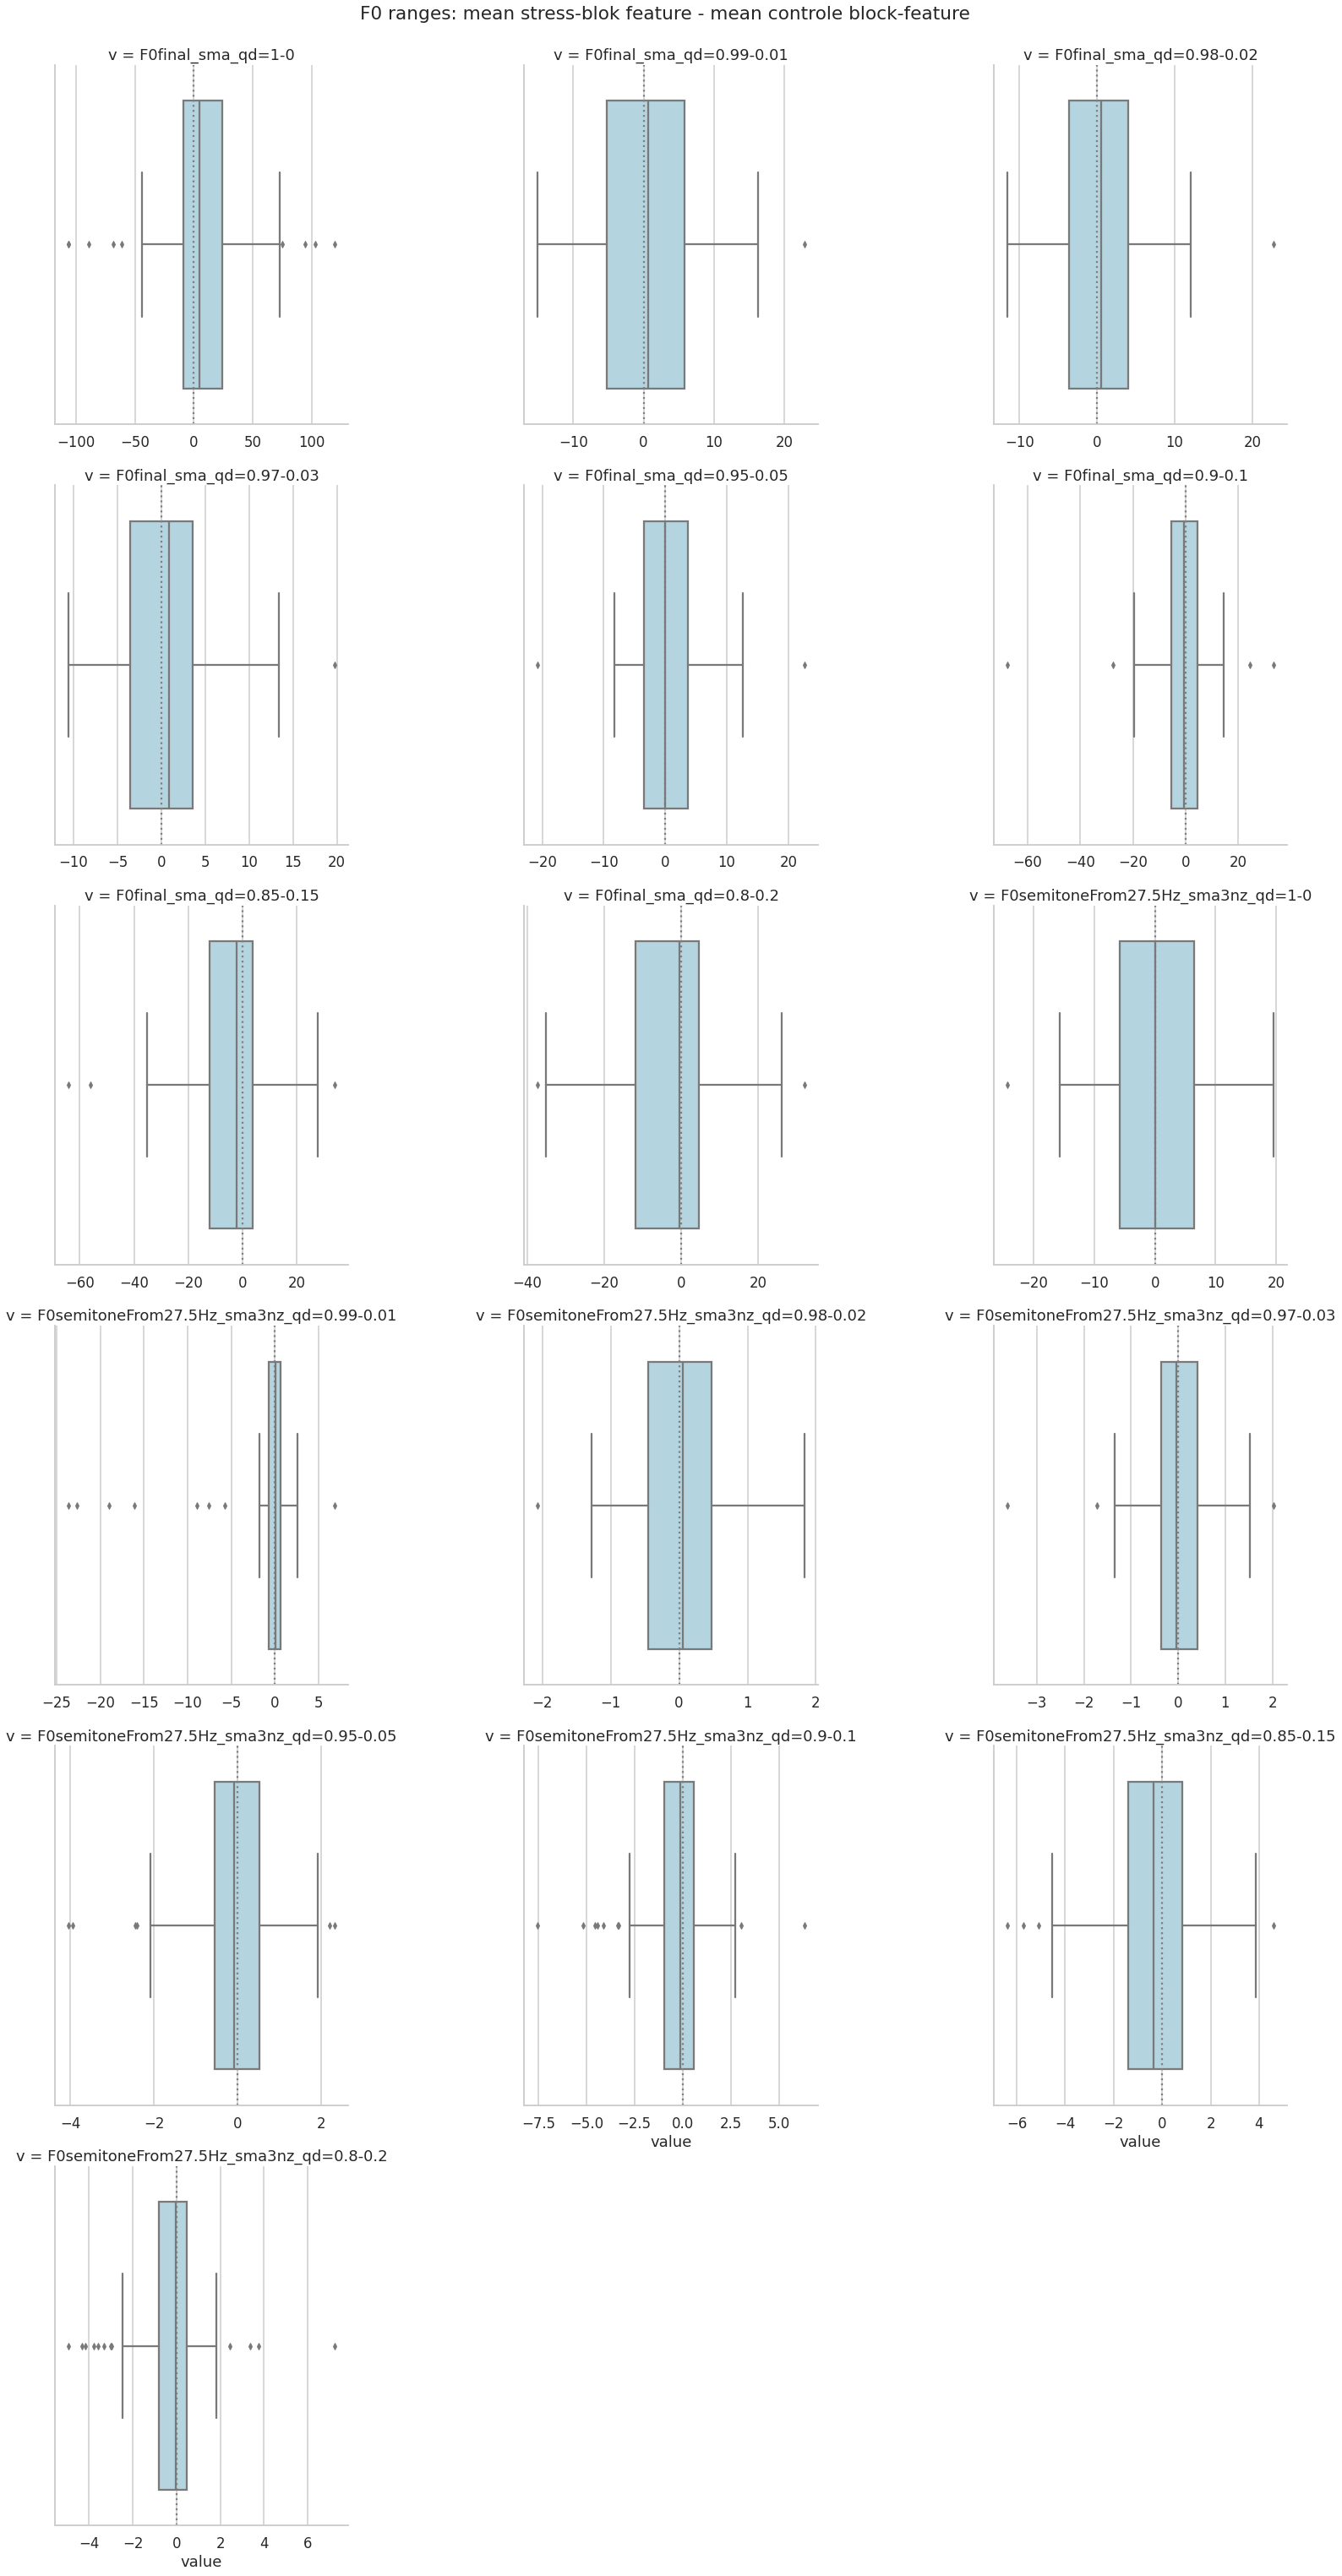

In [12]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(
                set(mean_stress_func.index)
                .difference(mean_contr_func.index)
                .union(set(mean_contr_func.index).difference(mean_stress_func.index))
            )
        )
    ].melt(var_name="v"),
    col="v",
    x="value",
    kind="box",
    height=7,
    col_wrap=3,
    sharex=False,
    color="lightblue",
)
g.fig.suptitle(
    "F0 ranges: mean stress-blok feature - mean control block-feature", y=1.01
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")
plt.subplots_adjust(wspace=0.6)